<a href="https://colab.research.google.com/github/SankalpC10/Colab_Notebooks/blob/main/Churn_classification_LTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Churn Prediction for Kaggle Acquire Valued Customer Challenge

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [3]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import tqdm
from typing import Sequence

In [74]:
import os

import numpy as np
import pandas as pd
import tqdm
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from typing import Sequence
import pickle

# install and import ltv
# !pip install -q git+https://github.com/google/lifetime_value
!pip install -q git+https://github.com/seyedrezamirkhani/lifetime_value
import lifetime_value as ltv

  Preparing metadata (setup.py) ... done


In [5]:
def zero_inflated_lognormal_pred(logits: tf.Tensor) -> tf.Tensor:
  """Calculates predicted mean of zero inflated lognormal logits.

  Arguments:
    logits: [batch_size, 3] tensor of logits.

  Returns:
    preds: [batch_size, 1] tensor of predicted mean.
  """
  logits = tf.convert_to_tensor(logits, dtype=tf.float32)
  positive_probs = tf.keras.backend.sigmoid(logits[..., :1])
  loc = logits[..., 1:2]
  scale = tf.keras.backend.softplus(logits[..., 2:])
  preds = (
      positive_probs *
      tf.keras.backend.exp(loc + 0.5 * tf.keras.backend.square(scale)))
  return preds

@tf.keras.utils.register_keras_serializable()
def zero_inflated_lognormal_loss(labels: tf.Tensor,
                                 logits: tf.Tensor) -> tf.Tensor:
  """Computes the zero inflated lognormal loss.

  Usage with tf.keras API:

  ```python
  model = tf.keras.Model(inputs, outputs)
  model.compile('sgd', loss=zero_inflated_lognormal)
  ```

  Arguments:
    labels: True targets, tensor of shape [batch_size, 1].
    logits: Logits of output layer, tensor of shape [batch_size, 3].

  Returns:
    Zero inflated lognormal loss value.
  """
  labels = tf.convert_to_tensor(labels, dtype=tf.float32)
  positive = tf.cast(labels > 0, tf.float32)

  logits = tf.convert_to_tensor(logits, dtype=tf.float32)
  logits.shape.assert_is_compatible_with(
      tf.TensorShape(labels.shape[:-1].as_list() + [3]))

  positive_logits = logits[..., :1]
  classification_loss = tf.keras.losses.binary_crossentropy(
      y_true=positive, y_pred=positive_logits, from_logits=True)

  loc = logits[..., 1:2]
  scale = tf.math.maximum(
      tf.keras.backend.softplus(logits[..., 2:]),
      tf.math.sqrt(tf.keras.backend.epsilon()))
  safe_labels = positive * labels + (
      1 - positive) * tf.keras.backend.ones_like(labels)
  regression_loss = -tf.keras.backend.mean(
      positive * tfd.LogNormal(loc=loc, scale=scale).log_prob(safe_labels),
      axis=-1)

  return classification_loss + regression_loss

In [6]:
tfd = tfp.distributions
pd.options.mode.chained_assignment = None  # default='warn'

## Global variables

In [7]:
COMPANY = '104900040'  # @param { isTemplate: true, type: 'string'}
LOSS = 'ziln'  # @param { isTemplate: true, type: 'string'} ['bce', 'ziln']
# LOSS = 'bce'  # @param { isTemplate: true, type: 'string'} ['bce', 'ziln']
# MODEL = 'linear'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
MODEL = 'dnn'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param {type: 'integer'}
DATA_FOLDER = './tmp/acquire-valued-shoppers-challenge' # @param { isTemplate: true, type: 'string'}
OUTPUT_CSV_FOLDER = f'{DATA_FOLDER}/result'  # @param { isTemplate: true, type: 'string'}

In [8]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

In [9]:
# Set it DATA_FOLDER as an environment variable
%env DATA_FOLDER=$DATA_FOLDER

env: DATA_FOLDER=./tmp/acquire-valued-shoppers-challenge


## Data

### Download data

Setup kaggle API correctly following https://www.kaggle.com/docs/api
```
%%shell
mkdir ~/.kaggle
echo \{\"username\":\"{your kaggle username}\",\"key\":\"{your kaggle api key}\"\} > ~/.kaggle/kaggle.json
pip install kaggle
```

In [10]:
%%shell
mkdir ~/.kaggle
echo \{\"username\":\"sankalpchavhan\",\"key\":\"c2c7e3b5079f84cb89cb3557fbcc2aa2\"\} > ~/.kaggle/kaggle.json
pip install kaggle

In [11]:
%%bash
if [ -e $DATA_FOLDER/transactions.csv ]
then
  echo "File already exists, no need to download."
else
  rm -rf $DATA_FOLDER
  mkdir -p $DATA_FOLDER
  cd $DATA_FOLDER
  kaggle competitions download -c acquire-valued-shoppers-challenge
  echo "Unzip file. This may take 10 min."
  unzip acquire-valued-shoppers-challenge.zip transactions.csv.gz
  gunzip transactions.csv.gz
fi


Unzip file. This may take 10 min.
Archive:  acquire-valued-shoppers-challenge.zip
  inflating: transactions.csv.gz     


100%|██████████| 2.86G/2.86G [00:38<00:00, 79.9MB/s]


### Load transaction csv

In [137]:
def load_transaction_data(company):
  all_data_filename = f'{DATA_FOLDER}/transactions.csv'
  one_company_data_filename = f'{DATA_FOLDER}/transactions_company_{company}.csv'
  if os.path.isfile(one_company_data_filename):
    df = pd.read_csv(one_company_data_filename)
  else:
    data_list = []
    chunksize = 10**6
    # 350 iterations
    for chunk in tqdm.tqdm(pd.read_csv(all_data_filename, chunksize=chunksize)):
      data_list.append(chunk.query("company=={}".format(company)))
    df = pd.concat(data_list, axis=0)
    df.to_csv(one_company_data_filename, index=None)
  return df

### Preprocess data

In [138]:
def preprocess(df):
  df = df.query('purchaseamount>0')
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
  df['start_date'] = df.groupby('id')['date'].transform('min')

  # Compute calibration values
  calibration_value = (
      df.query('date==start_date').groupby('id')
      ['purchaseamount'].sum().reset_index())
  calibration_value.columns = ['id', 'calibration_value']

  # Compute holdout values
  one_year_holdout_window_mask = (
      (df['date'] > df['start_date']) &
      (df['date'] <= df['start_date'] + np.timedelta64(365, 'D')))
  holdout_value = (
      df[one_year_holdout_window_mask].groupby('id')
      ['purchaseamount'].sum().reset_index())
  holdout_value.columns = ['id', 'holdout_value']

  # Compute calibration attributes
  calibration_attributes = (
      df.query('date==start_date').sort_values(
          'purchaseamount', ascending=False).groupby('id')[[
              'chain', 'dept', 'category', 'brand', 'productmeasure'
          ]].first().reset_index())

  # Merge dataframes
  customer_level_data = (
      calibration_value.merge(calibration_attributes, how='left',
                              on='id').merge(
                                  holdout_value, how='left', on='id'))
  customer_level_data['holdout_value'] = (
      customer_level_data['holdout_value'].fillna(0.))
  customer_level_data[CATEGORICAL_FEATURES] = (
      customer_level_data[CATEGORICAL_FEATURES].fillna('UNKNOWN'))

  # Specify data types
  customer_level_data['log_calibration_value'] = (
      np.log(customer_level_data['calibration_value']).astype('float32'))
  customer_level_data['chain'] = (
      customer_level_data['chain'].astype('category'))
  customer_level_data['dept'] = (customer_level_data['dept'].astype('category'))
  customer_level_data['brand'] = (
      customer_level_data['brand'].astype('category'))
  customer_level_data['category'] = (
      customer_level_data['category'].astype('category'))
  customer_level_data['label'] = (
      customer_level_data['holdout_value'].astype('float32'))
  return customer_level_data

### Load customer-level csv

In [139]:
def load_customer_level_csv(company):
  customer_level_data_file = f'{DATA_FOLDER}/customer_level_data_company_{company}.csv'
  if os.path.isfile(customer_level_data_file):
    customer_level_data = pd.read_csv(customer_level_data_file)
  else:
    customer_level_data = preprocess(load_transaction_data(company))
  for cat_col in CATEGORICAL_FEATURES:
    customer_level_data[cat_col] = (
        customer_level_data[cat_col].astype('category'))
  for num_col in [
      'log_calibration_value', 'calibration_value', 'holdout_value'
  ]:
    customer_level_data[num_col] = (
        customer_level_data[num_col].astype('float32'))

  return customer_level_data

In [140]:
# Processes data. 350 iteration in total. May take 10min.
customer_level_data = load_customer_level_csv(COMPANY)

We observe a mixture of zero and lognormal distribution of holdout value.

<Axes: >

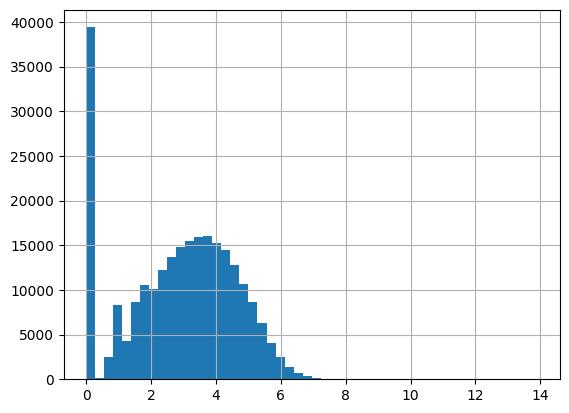

In [141]:
customer_level_data.label.apply(np.log1p).hist(bins=50)

In [155]:
customer_level_data

,id,calibration_value,chain,dept,category,brand,productmeasure,holdout_value,log_calibration_value,label
0,86246,11.58,205,36,3630,23359,OZ,358.260010,2.449280,358.260010
1,86252,0.99,205,21,2105,14357,OZ,336.649994,-0.010050,336.649994
2,12262064,1.72,95,21,2105,14357,OZ,32.310001,0.542324,32.310001
3,12277270,4.49,95,36,3601,3809,OZ,186.750000,1.501853,186.750000
4,12332190,1.49,95,36,3611,4599,OZ,53.610001,0.398776,53.610001
...,...,...,...,...,...,...,...,...,...,...
249280,4824696849,1.00,46,36,3601,3809,OZ,0.000000,0.000000,0.000000
249281,4829517835,6.98,46,36,3601,3809,OZ,0.000000,1.943049,0.000000
249282,4837642552,4.99,46,36,3611,4599,OZ,14.970000,1.607436,14.970000
249283,4847628950,16.65,166,36,3618,23359,OZ,71.110001,2.812410,71.110001


In [156]:
customer_level_data.head().T

,0,1,2,3,4
id,86246,86252,12262064,12277270,12332190
calibration_value,11.58,0.99,1.72,4.49,1.49
chain,205,205,95,95,95
dept,36,21,21,36,36
category,3630,2105,2105,3601,3611
brand,23359,14357,14357,3809,4599
productmeasure,OZ,OZ,OZ,OZ,OZ
holdout_value,358.26001,336.649994,32.310001,186.75,53.610001
log_calibration_value,2.44928,-0.01005,0.542324,1.501853,0.398776
label,358.26001,336.649994,32.310001,186.75,53.610001


## Data

### Make train/eval

In [157]:
def linear_split(df):
  # get_dummies preserves numeric features.
  x = pd.get_dummies(df[ALL_FEATURES], drop_first=True).astype('float32').values
  y = df['label'].values

  x_train, x_eval, y_train, y_eval = model_selection.train_test_split(
      x, y, test_size=0.2, random_state=123)

  return x_train, x_eval, y_train, y_eval

In [158]:
def dnn_split(df):
    encoder_dir = 'encoders'
    os.makedirs(encoder_dir, exist_ok=True)

    # Dictionary to store encoders
    encoders = {}
    for key in CATEGORICAL_FEATURES:
      encoder = preprocessing.LabelEncoder()
      df[key] = encoder.fit_transform(df[key])
      with open(os.path.join(encoder_dir, f"{key}_encoder.pkl"), 'wb') as f:
            pickle.dump(encoder, f)

      encoders[key] = encoder

    df_train, df_eval = model_selection.train_test_split(
        df, test_size=0.2, random_state=123)

    def feature_dict(df):
      features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
      features['numeric'] = df[NUMERIC_FEATURES].values
      return features

    x_train, y_train = feature_dict(df_train), df_train['label'].values
    x_eval, y_eval = feature_dict(df_eval), df_eval['label'].values

    return x_train, x_eval, y_train, y_eval

In [159]:
# def dnn_split(df, categorical_features, numeric_features, label_column):
#     # Directory to save encoders
#     encoder_dir = 'encoders'
#     os.makedirs(encoder_dir, exist_ok=True)

#     # Dictionary to store encoders
#     encoders = {}

#     # Apply LabelEncoder to categorical features and save encoders
#     for key in categorical_features:
#         encoder = preprocessing.LabelEncoder()
#         df[key] = encoder.fit_transform(df[key])

#         # Save the encoder for later use
#         with open(os.path.join(encoder_dir, f"{key}_encoder.pkl"), 'wb') as f:
#             pickle.dump(encoder, f)

#         # Store the encoder in the dictionary
#         encoders[key] = encoder

#     # Split the dataset into training and evaluation sets
#     df_train, df_eval = model_selection.train_test_split(df, test_size=0.2, random_state=123)

#     def feature_dict(df):
#         features = {k: v.values for k, v in dict(df[categorical_features]).items()}
#         features['numeric'] = df[numeric_features].values
#         return features

#     x_train, y_train = feature_dict(df_train), df_train[label_column].values
#     x_eval, y_eval = feature_dict(df_eval), df_eval[label_column].values

#     return x_train, x_eval, y_train, y_eval, encoders

## Model

In [160]:
def linear_model(output_units, input_dim):
  return tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(output_units, activation=None)
  ])

In [161]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size)
      ),
      tf.keras.layers.Flatten(),
  ])


def dnn_model(output_units, df):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')

  embedding_inputs = [
      tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
      for key in CATEGORICAL_FEATURES
  ]

  embedding_outputs = [
      # embedding_layer(vocab_size=df[key].nunique())(input)
      embedding_layer(vocab_size=134)(input)
      for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  ]

  deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(output_units),
  ])
  return tf.keras.Model(
      inputs=[numeric_input] + embedding_inputs, outputs=deep_model(deep_input))

### Train

In [162]:
if LOSS == 'bce':
  loss = keras.losses.BinaryCrossentropy(from_logits=True)
  output_units = 1

if LOSS == 'ziln':
  loss = zero_inflated_lognormal_loss
  output_units = 3

In [163]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval = linear_split(customer_level_data)
  model = linear_model(output_units, x_train.shape[1])

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval = dnn_split(customer_level_data)
  model = dnn_model(output_units, customer_level_data)

In [164]:
if LOSS == 'bce':
  y_train = (y_train > 0).astype('float32')
  y_eval = (y_eval > 0).astype('float32')

In [165]:
model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [166]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [167]:
for key in CATEGORICAL_FEATURES:
    print(f"{key} max value after encoding: {customer_level_data[key].max()}")

chain max value after encoding: 132
dept max value after encoding: 3
category max value after encoding: 19
brand max value after encoding: 20
productmeasure max value after encoding: 0


In [168]:
for key in CATEGORICAL_FEATURES:
    print(f"{key} vocab size: {customer_level_data[key].nunique()}")

chain vocab size: 133
dept vocab size: 4
category vocab size: 20
brand vocab size: 21
productmeasure vocab size: 1


In [169]:
customer_level_data

,id,calibration_value,chain,dept,category,brand,productmeasure,holdout_value,log_calibration_value,label
0,86246,11.58,69,3,14,14,0,358.260010,2.449280,358.260010
1,86252,0.99,69,2,2,10,0,336.649994,-0.010050,336.649994
2,12262064,1.72,39,2,2,10,0,32.310001,0.542324,32.310001
3,12277270,4.49,39,3,4,1,0,186.750000,1.501853,186.750000
4,12332190,1.49,39,3,6,2,0,53.610001,0.398776,53.610001
...,...,...,...,...,...,...,...,...,...,...
249280,4824696849,1.00,21,3,4,1,0,0.000000,0.000000,0.000000
249281,4829517835,6.98,21,3,4,1,0,0.000000,1.943049,0.000000
249282,4837642552,4.99,21,3,6,2,0,14.970000,1.607436,14.970000
249283,4847628950,16.65,62,3,8,14,0,71.110001,2.812410,71.110001


In [170]:
customer_level_data['chain'].nunique()

133

In [171]:
history = model.fit(
    x=x_train,
    y=y_train[:, np.newaxis],
    batch_size=1024,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval[:, np.newaxis])).history

Epoch 1/400
195/195 - 4s - 18ms/step - loss: 5.6735 - val_loss: 4.7936 - learning_rate: 2.0000e-04
Epoch 2/400
195/195 - 2s - 12ms/step - loss: 4.7164 - val_loss: 4.6911 - learning_rate: 2.0000e-04
Epoch 3/400
195/195 - 1s - 6ms/step - loss: 4.6659 - val_loss: 4.6638 - learning_rate: 2.0000e-04
Epoch 4/400
195/195 - 1s - 5ms/step - loss: 4.6438 - val_loss: 4.6485 - learning_rate: 2.0000e-04
Epoch 5/400
195/195 - 2s - 8ms/step - loss: 4.6329 - val_loss: 4.6411 - learning_rate: 2.0000e-04
Epoch 6/400
195/195 - 2s - 9ms/step - loss: 4.6269 - val_loss: 4.6362 - learning_rate: 2.0000e-04
Epoch 7/400
195/195 - 2s - 9ms/step - loss: 4.6232 - val_loss: 4.6334 - learning_rate: 2.0000e-04
Epoch 8/400
195/195 - 1s - 5ms/step - loss: 4.6205 - val_loss: 4.6309 - learning_rate: 2.0000e-04
Epoch 9/400
195/195 - 1s - 6ms/step - loss: 4.6188 - val_loss: 4.6292 - learning_rate: 2.0000e-04
Epoch 10/400
195/195 - 1s - 5ms/step - loss: 4.6172 - val_loss: 4.6280 - learning_rate: 2.0000e-04
Epoch 11/400
195/

<Axes: >

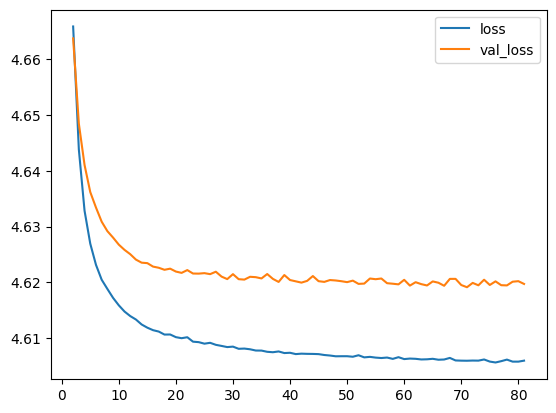

In [172]:
pd.DataFrame(history)[['loss', 'val_loss']][2:].plot()

### Eval

In [173]:
logits = model.predict(x=x_eval, batch_size=1024)
y_pred = K.sigmoid(logits[..., :1]).numpy().flatten()

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [174]:
x_train

{'chain': array([ 14,  21, 106, ...,  14,  33,  11]),
 'dept': array([3, 3, 3, ..., 3, 3, 3]),
 'category': array([ 4,  8, 10, ..., 14, 10,  8]),
 'brand': array([ 1, 14, 11, ..., 14, 11, 14]),
 'productmeasure': array([0, 0, 0, ..., 0, 0, 0]),
 'numeric': array([[1.7917595 ],
        [1.2029723 ],
        [1.178655  ],
        ...,
        [2.014903  ],
        [0.51282364],
        [1.0986123 ]], dtype=float32)}

In [175]:
x_eval

{'chain': array([ 14,  14,   9, ..., 110,  18,  21]),
 'dept': array([3, 3, 3, ..., 3, 3, 3]),
 'category': array([ 8,  6,  8, ...,  4, 10,  4]),
 'brand': array([14,  2, 14, ...,  1, 11,  1]),
 'productmeasure': array([0, 0, 0, ..., 0, 0, 0]),
 'numeric': array([[-0.01005034],
        [ 2.0769384 ],
        [ 1.5040774 ],
        ...,
        [ 0.46373403],
        [ 1.9139771 ],
        [ 1.7917595 ]], dtype=float32)}

In [176]:
logits

array([[1.6643212, 3.203326 , 1.0585228],
       [1.6711224, 3.574435 , 1.0209956],
       [1.9363171, 3.4792337, 1.1008466],
       ...,
       [0.8070926, 2.2972062, 0.9532978],
       [1.7037501, 3.1383631, 1.1778969],
       [1.477343 , 3.1615236, 0.9012335]], dtype=float32)

In [177]:
y_pred

array([0.8408172 , 0.8417254 , 0.873947  , ..., 0.6914897 , 0.84602386,
       0.8141709 ], dtype=float32)

In [178]:
y_eval

array([ 19.21,   0.  , 165.  , ...,  15.46,  71.21,  61.46], dtype=float32)

In [207]:
y_pred.max()

0.98802054

In [179]:
y_true = (y_eval > 0).astype('float32')

In [180]:
def classification_report(y_true: Sequence[int],
                          y_pred: Sequence[float]) -> pd.DataFrame:
  """Report individual level classification metrics.

  Arguments:
    y_true: true binary labels.
    y_pred: predicted binary labels.

  Returns:
    out: dataframe with classification metrics as columns.
  """
  out = pd.DataFrame(index=[0])

  out['AUC'] = metrics.roc_auc_score(y_true, y_pred)
  out['PR_AUC'] = metrics.average_precision_score(y_true, y_pred)
  out['precision'] = metrics.precision_score(y_true, 1 * (y_pred > .5))
  out['recall'] = metrics.recall_score(y_true, 1 * (y_pred > .5))
  out['f1'] = metrics.f1_score(y_true, 1 * (y_pred > .5))
  return out

In [181]:
classification = classification_report(y_true, y_pred)
classification

,AUC,PR_AUC,precision,recall,f1
0,0.656902,0.90568,0.845845,0.997197,0.915307


### All metrics together

In [182]:
df_metrics = pd.DataFrame(
    {
        'company': COMPANY,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_true.mean(),
        'pred_mean': y_pred.mean(),
        'AUC': classification.loc[0, 'AUC'],
        'PR_AUC': classification.loc[0, 'PR_AUC'],
        'precision': classification.loc[0, 'precision'],
        'recall': classification.loc[0, 'recall'],
        'f1': classification.loc[0, 'f1']
    },
    index=[0])

In [183]:
df_metrics[[
    'company',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'AUC',
    'PR_AUC',
    'precision',
    'recall',
    'f1',
]]

,company,model,loss,label_mean,pred_mean,AUC,PR_AUC,precision,recall,f1
0,104900040,dnn,ziln,0.844395,0.839177,0.656902,0.90568,0.845845,0.997197,0.915307


## Save

In [184]:
output_path = os.path.join(OUTPUT_CSV_FOLDER, COMPANY)

In [185]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [186]:
output_file = os.path.join(output_path,
                           '{}_classification_{}.csv'.format(MODEL, LOSS))

In [187]:
df_metrics.to_csv(output_file, index=False)

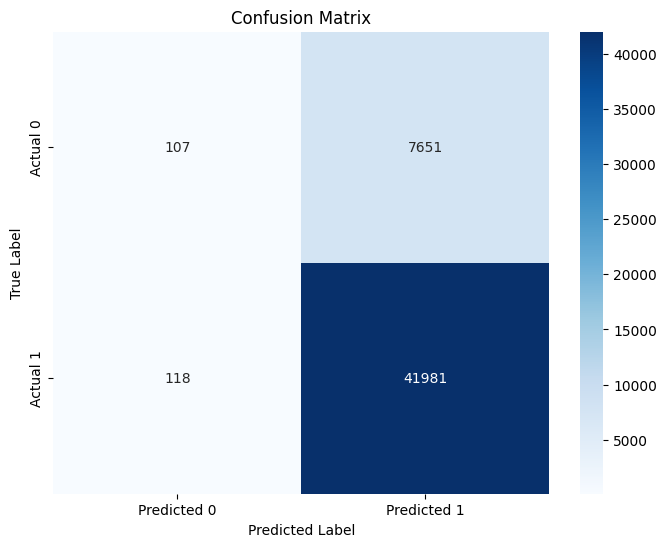

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are defined from the previous code
# Example:
# y_true = (y_eval > 0).astype('float32')
# y_pred = K.sigmoid(logits[..., :1]).numpy().flatten()


# Calculate the confusion matrix
cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [189]:
def predict(chain, dept, category, brand, productmeasure, log_calibration_value):
    """Predicts the holdout value based on input features."""

    # Create a DataFrame from the input values
    input_data = pd.DataFrame({
        'chain': [chain],
        'dept': [dept],
        'category': [category],
        'brand': [brand],
        'productmeasure': [productmeasure],
        'log_calibration_value': [log_calibration_value]
    })

    # Preprocess the input data (mimicking the preprocessing steps in the original code)
    for col in ['chain', 'dept', 'category', 'brand', 'productmeasure']:
        le = preprocessing.LabelEncoder()
        # Fit the label encoder using the original training data (customer_level_data)
        le.fit(customer_level_data[col])
        input_data[col] = le.transform(input_data[col])

    # Prepare the input for the model
    numeric_input = input_data[['log_calibration_value']].values
    categorical_inputs = [input_data[col].values for col in ['chain', 'dept', 'category', 'brand', 'productmeasure']]
    input_dict = {'numeric': numeric_input}
    for i, col in enumerate(['chain', 'dept', 'category', 'brand', 'productmeasure']):
        input_dict[col] = categorical_inputs[i]

    # Make the prediction
    logits = model.predict(input_dict)

    # Process the output based on the loss function used
    if LOSS == 'bce':
        prediction = K.sigmoid(logits).numpy().flatten()[0]
    elif LOSS == 'ziln':
        # For zero-inflated lognormal, you'll need to handle the 3-element output.
        #  This example just returns the first element for simplicity.
        prediction = logits[0,0]
    else:
        prediction = 0

    return prediction

In [190]:
# prompt: provide sample input for above function

# Example usage of the predict function
chain = '69'  # Replace with an actual chain value from the dataset
dept = '3' # Replace with an actual dept value from the dataset
category = '14' # Replace with an actual category value from the dataset
brand = '14' # Replace with an actual brand value from the dataset
productmeasure = '0'  # Replace with an actual productmeasure value from the dataset
log_calibration_value = 1  # Replace with an actual log_calibration_value


prediction = predict(chain, dept, category, brand, productmeasure, log_calibration_value)
print(f"Prediction: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Prediction: 2.2576119899749756


In [191]:
# prompt: What is the actual prediction value?

def predict(chain, dept, category, brand, productmeasure, log_calibration_value):
    """Predicts the holdout value based on input features."""

    # Create a DataFrame from the input values
    input_data = pd.DataFrame({
        'chain': [chain],
        'dept': [dept],
        'category': [category],
        'brand': [brand],
        'productmeasure': [productmeasure],
        'log_calibration_value': [log_calibration_value]
    })

    # Preprocess the input data (mimicking the preprocessing steps in the original code)
    for col in ['chain', 'dept', 'category', 'brand', 'productmeasure']:
        le = preprocessing.LabelEncoder()
        # Fit the label encoder using the original training data (customer_level_data)
        le.fit(customer_level_data[col])
        input_data[col] = le.transform(input_data[col])

    # Prepare the input for the model
    numeric_input = input_data[['log_calibration_value']].values
    categorical_inputs = [input_data[col].values for col in ['chain', 'dept', 'category', 'brand', 'productmeasure']]
    input_dict = {'numeric': numeric_input}
    for i, col in enumerate(['chain', 'dept', 'category', 'brand', 'productmeasure']):
        input_dict[col] = categorical_inputs[i]

    # Make the prediction
    logits = model.predict(input_dict)

    # Process the output based on the loss function used
    if LOSS == 'bce':
        prediction = K.sigmoid(logits).numpy().flatten()[0]
    elif LOSS == 'ziln':
        # For zero-inflated lognormal, you'll need to handle the 3-element output.
        #  This example just returns the first element for simplicity.
        prediction = logits[0,0]
    else:
        prediction = 0

    return prediction

# Example usage of the predict function
chain = '69'  # Replace with an actual chain value from the dataset
dept = '3' # Replace with an actual dept value from the dataset
category = '14' # Replace with an actual category value from the dataset
brand = '14' # Replace with an actual brand value from the dataset
productmeasure = '0'  # Replace with an actual productmeasure value from the dataset
log_calibration_value = 1  # Replace with an actual log_calibration_value


prediction = predict(chain, dept, category, brand, productmeasure, log_calibration_value)
print(f"Prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction: 2.2576119899749756


In [192]:
def predict_with_model(model, inputs, categorical_features, numeric_features, batch_size=1024):
    """
    Predict output values using a trained model.

    Parameters:
    - model: Trained TensorFlow/Keras model.
    - inputs: A DataFrame or dictionary containing input data.
    - categorical_features: List of categorical feature names.
    - numeric_features: List of numeric feature names.
    - batch_size: Batch size for prediction (default=1024).

    Returns:
    - A 1D NumPy array of predicted probabilities.
    """
    # Ensure inputs are preprocessed as per model requirements
    features = {}
    for feature in categorical_features:
        features[feature] = inputs[feature].values

    features['numeric'] = inputs[numeric_features].values

    # Predict logits
    logits = model.predict(x=features, batch_size=batch_size)

    # Apply sigmoid activation to get probabilities
    probabilities = K.sigmoid(logits[..., :1]).numpy().flatten()

    return probabilities

In [193]:
customer_level_data.head()

,id,calibration_value,chain,dept,category,brand,productmeasure,holdout_value,log_calibration_value,label
0,86246,11.58,69,3,14,14,0,358.260010,2.449280,358.260010
1,86252,0.99,69,2,2,10,0,336.649994,-0.010050,336.649994
2,12262064,1.72,39,2,2,10,0,32.310001,0.542324,32.310001
3,12277270,4.49,39,3,4,1,0,186.750000,1.501853,186.750000
4,12332190,1.49,39,3,6,2,0,53.610001,0.398776,53.610001


In [194]:
sample_data = pd.DataFrame({
    'chain': [69],
    'dept': [3],
    'category': [14],
    'brand': [14],
    'productmeasure': [0],
    'log_calibration_value': [2.44]
})

categorical_features = ['chain', 'dept', 'category', 'brand', 'productmeasure']
numeric_features = ['log_calibration_value']

# Call the function
predictions = predict_with_model(model, sample_data, categorical_features, numeric_features)

print("Predicted Probabilities:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Probabilities: [0.9406768]


In [195]:
# prompt: save the model with .h5 extension

model.save('ltv_model.keras')

In [196]:
!dir

encoders  ltv_model.keras  sample_data	tmp


In [197]:
log_calibration_value

1

In [210]:
customer_level_data['log_calibration_value'].mean()

1.3620551

In [199]:
def load_encoders(categorical_features):
    encoders = {}
    encoder_dir = 'encoders'

    # Load each encoder
    for key in categorical_features:
        with open(os.path.join(encoder_dir, f"{key}_encoder.pkl"), 'rb') as f:
            encoders[key] = pickle.load(f)

    return encoders

def transform_new_data(df, categorical_features, numeric_features, encoders):
    # Transform categorical features using the loaded encoders
    for key in categorical_features:
        encoder = encoders[key]
        df[key] = encoder.transform(df[key])

    # Return the transformed features (numeric values are unchanged)
    features = {k: v.values for k, v in dict(df[categorical_features]).items()}
    features['numeric'] = df[numeric_features].values
    return features

In [200]:
encoders = load_encoders(CATEGORICAL_FEATURES)

In [201]:
encoders

{'chain': LabelEncoder(),
 'dept': LabelEncoder(),
 'category': LabelEncoder(),
 'brand': LabelEncoder(),
 'productmeasure': LabelEncoder()}

In [202]:
for i in encoders:
    print(encoders[i].classes_)

[  2   3   4   6   8   9  10  12  14  15  16  17  18  20  21  23  24  26
  31  40  42  46  48  58  62  63  64  65  68  69  70  71  73  77  81  83
  85  88  89  95  96  98 100 101 104 106 108 109 115 116 122 126 133 134
 140 143 151 152 153 161 163 165 166 169 180 184 187 191 192 205 206 211
 214 215 217 224 230 233 240 241 246 278 284 285 293 304 306 307 313 356
 360 362 368 369 370 373 376 377 384 386 387 388 389 390 391 392 393 394
 395 396 397 398 399 400 401 402 403 404 405 422 424 431 507 508 509 510
 520 521 522 523 524 525 526]
[ 6  7 21 36]
[ 610  706 2105 2119 3601 3604 3611 3613 3618 3625 3626 3627 3628 3629
 3630 3631 3632 3636 3638 3699]
[ 1414  3809  4599  6137  6716  6869  8740 11484 11749 12086 14357 17186
 17929 20736 23359 23363 39602 55528 68664 69531 74593]
['OZ']


In [205]:
encoders['chain'].transform([69])

array([29])

# Log Calibration Value

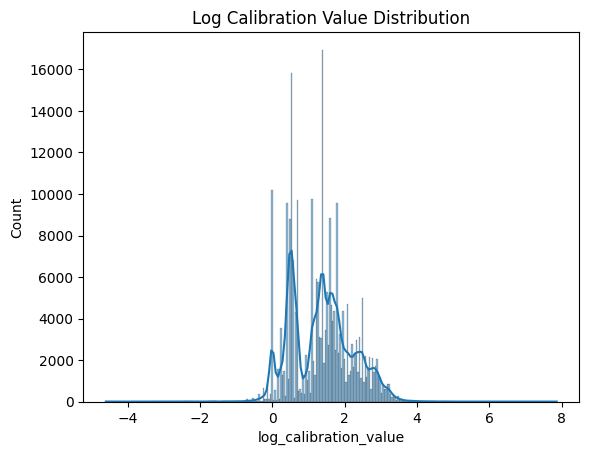

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(customer_level_data['log_calibration_value'], kde=True)
plt.title('Log Calibration Value Distribution')
plt.show()

In [212]:
skewness = customer_level_data['log_calibration_value'].skew()
print(f"Skewness: {skewness}")

Skewness: 0.22711531817913055


In [214]:
customer_level_data['transformed_value'] = customer_level_data['log_calibration_value'].apply(lambda x: np.log1p(x))

<ipython-input-214-0d0a0420ac31>:1: RuntimeWarning: invalid value encountered in log1p
  customer_level_data['transformed_value'] = customer_level_data['log_calibration_value'].apply(lambda x: np.log1p(x))
